In [2]:
import numpy as np
import scipy.sparse as sp
import time
import matplotlib.pyplot as plt

def lagrange_basis(integrationType, coord, dim):
    dim = 1
    if integrationType == "L2":
        xi = coord
        N = np.array([(1 - xi) / 2, (1 + xi) / 2]).reshape(-1, 1)
        dNdxi = np.array([-1, 1]) / 2

    I = np.eye(dim)
    Nv = []
    for i in range(N.shape[0]):
        Nv.append(np.eye(dim) * N[i])
    Nv = np.vstack(Nv)
    if dim == 1:
        B = dNdxi
    return Nv, dNdxi
    


In [3]:
# Time
duration = 240 * 60 #* 60  # [s]
dt = 360  # [s]
nstep = round(duration / dt)
Time = np.zeros(nstep + 1)

# General properties
poro = 1.0  # Initial porosity
rho_s = 2000  # Density of soil [kg/m3]
rho_w = 1000  # Density of water [kg/m3]
rho_i = 920  # Density of ice [kg/m3]
gravity = 9.81  # Gravity [m/s2]

# Thermal properties
Tr = 273.15  # Reference temperature [K]
k_parameter = 5.0
landa_s = 1.1  # Thermal conductivity of soil [J/s/m/K]
landa_w = 0.58  # Thermal conductivity of water [J/s/m/K]
landa_i = 2.20  # Thermal conductivity of ice [J/s/m/K]
cap_s = 900  # Specific heat capacity of soil [J/kg/K]
cap_w = 4190  # Specific heat capacity of water [J/kg/K]
cap_i = 2090  # Specific heat capacity of ice [J/kg/K]
Lf = 3.34e5  # Latent heat of fusion [J/kg]

# Element properties
elemType1 = "L2"
integ = "GAUSS"
order1 = 2

# Mesh and geometry
bar_length = 4  # Length of the bar in meters
dx = 0.005  # Node spacing in meters

# Number of nodes
numnode = int(bar_length / dx + 1)

# Generate node coordinates
node = np.linspace(0, bar_length, numnode)

# Generate element connectivity
numelem = numnode - 1
element = np.zeros((numelem, 2), dtype=int)
for i in range(numelem):
    element[i, :] = [i + 1, i + 2]
FixedNodesT = np.array([1, 801])

# Define variables
total_unknown = numnode
temp_unknown = numnode

# Initial conditions
T = np.zeros(numnode) + 263.15
T[0] = 308.15

# Degree of freedom
Tdofs = FixedNodesT

# Number of dofs
numTdof = numnode

# Initial conditions
Xn = T
tol_r = 1e-6
Q1 = np.array([1/np.sqrt(3), -1/np.sqrt(3)])  # Quadrature points
W1 = np.array([1, 1])  # Weights

arr = np.zeros((nstep, len(T)))


for step in range(nstep):
    converged = False
    iter = 0

    # Stiffness matrix
    Ktt = sp.lil_matrix((numnode, numnode))
    Ctt = sp.lil_matrix((numnode, numnode))

    # Forces
    fT = np.zeros(temp_unknown)

    # Final unknowns
    X_new = Xn
    T = X_new

    for iel in range(numelem):
        sctrT = element[iel, :]

        for jel in range(W1.shape[0]):
            pt = Q1[jel]
            # Bfem and Nfem for Q4
            sctrT = element[iel, :]
            nn = len(sctrT)
            N, dNdxi = lagrange_basis(elemType1,pt,1)

            J0 = node[sctrT-1].T @ dNdxi  # Element Jacobian matrix
            dNdx = dNdxi / J0  # Compute derivatives of N w.r.t XY
    
            Nt = N.T  # Transpose of N
            Bt = np.zeros((1, nn))  # Create a 1 × nn zero matrix
            Bt[0, :nn] = dNdx[:nn]  # Assign the first column of dNdx to Bt
            T_temp = np.dot(Nt, T[sctrT-1])

            X = np.exp(k_parameter * (T_temp - Tr))
            si = 1 / (1 + X)
            dsidT = -k_parameter * X / (1 + X) / (1 + X)
            sw = 1 - si

            landa = (1 - poro) * landa_s + (poro * sw) * landa_w + (poro * si) * landa_i
            rhoc_eff = (1 - poro) * rho_s * cap_s + (poro * sw) * rho_w * cap_w + (poro * si) * rho_i * cap_i
            Ktt[np.ix_(sctrT-1, sctrT-1)] += Bt.T * landa * Bt * W1[jel] * J0
            Ctt[np.ix_(sctrT-1, sctrT-1)] += Nt.T * (rhoc_eff - Lf * rho_i * poro * dsidT) * Nt * W1[jel] * J0 
    Jacoubian = Ctt / dt + Ktt 
    C_matrix = Ctt
    K_matrix = Ktt

    Fext = fT
    residual = Fext - K_matrix * Xn

    Jacoubian = Jacoubian.toarray()
    bcwt = np.mean(np.diag(Jacoubian))

    # Temperature Constraints
    Jacoubian[Tdofs-1, :] = 0
    Jacoubian[:, Tdofs-1] = 0   
    Jacoubian[Tdofs[:, None]-1, Tdofs-1] = bcwt * sp.eye(len(Tdofs-1)).toarray()
    residual[Tdofs-1] = 0
    while not converged:
        iter += 1

        dX = np.linalg.solve(Jacoubian, residual)
        X_new = X_new + dX
        
        residual = Fext + C_matrix @ (Xn / dt) - (K_matrix + C_matrix / dt) @ X_new
        residual[Tdofs-1] = 0; #123

        print(f"Norm In iter({iter})={np.linalg.norm(residual)}")
        if np.linalg.norm(residual) < tol_r:
            converged = True
            print("converged!")  
            
    arr[step] = T
    T = X_new
    Xn = T
    
    toc = time.time()  # Assuming toc is the current time in seconds 123
    sec  = int(toc % 60)
    mint = int((toc // 60) % 60)
    hr   = int(toc // 3600)

    print(f"\t\t\t {step+1} Step")
    print(f"\t\t\t {iter} Iterations")
    print(f"\t Elapsed time {hr:02.0f}:{mint:02.0f}:{sec:02.0f}")
    print("--------------------------------------------------------------")

    Time[step] = (step) * dt
    
    if Time[step+1] == 4*60*60:
        T4 = T
    elif Time[step+1] == 12*60*60:
        T12 = T
    elif Time[step+1] == 28*60*60:
        T28 = T
    elif Time[step+1] == 60*60*60:
        T60 = T
    elif Time[step+1] == 124*60*60:
        T124 = T
    elif Time[step+1] == 240*60*60:
        T240 = T

print(arr)


Norm In iter(1)=8.335353960853598e-10
converged!
			 1 Step
			 1 Iterations
	 Elapsed time 483472:01:42
--------------------------------------------------------------
Norm In iter(1)=7.069986182393276e-10
converged!
			 2 Step
			 1 Iterations
	 Elapsed time 483472:01:43
--------------------------------------------------------------
Norm In iter(1)=7.918905135560885e-10
converged!
			 3 Step
			 1 Iterations
	 Elapsed time 483472:01:44
--------------------------------------------------------------
Norm In iter(1)=7.290273755889993e-10
converged!
			 4 Step
			 1 Iterations
	 Elapsed time 483472:01:45
--------------------------------------------------------------
Norm In iter(1)=7.18254402695989e-10
converged!
			 5 Step
			 1 Iterations
	 Elapsed time 483472:01:46
--------------------------------------------------------------
Norm In iter(1)=7.361863838091336e-10
converged!
			 6 Step
			 1 Iterations
	 Elapsed time 483472:01:47
--------------------------------------------------------

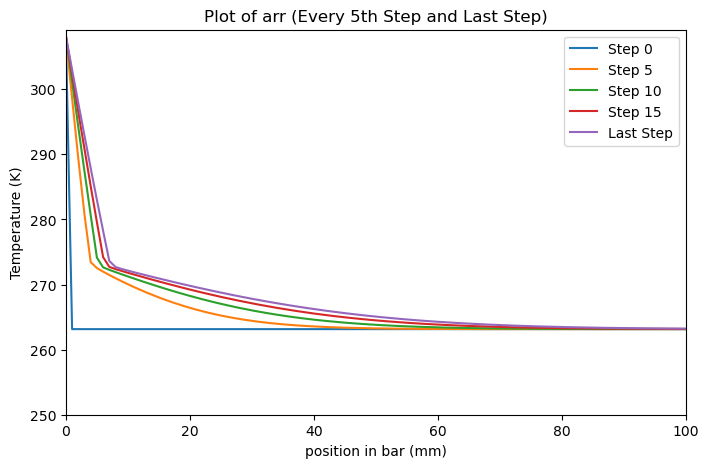

In [5]:
# Select every 5th step (adjust the step size as needed)
steps_to_plot = arr[::10]  # Every 5th step
last_step = arr[-1:]  # Last step

# Combine the selections for plotting
steps_to_plot_combined = np.vstack([steps_to_plot, last_step])

# Plot each selected step as a separate line
plt.figure(figsize=(8, 5))
for i in range(steps_to_plot_combined.shape[0]):
    plt.plot(steps_to_plot_combined[i], label=f"Step {i * 5}" if i < steps_to_plot.shape[0] else f"Last Step")

# Set the x-axis limit to the range 0-100
plt.xlim(0, 100)
# Set the y-axis starting from 250
plt.ylim(250, np.max(arr) + 1)

plt.xlabel("position in bar (mm)")
plt.ylabel("Temperature (K)")
plt.title("Plot of arr (Every 5th Step and Last Step)")
plt.legend()
plt.show()